In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#please specify  your own root
root = '/content/drive/MyDrive/JunctionX/Data_preprocess'

In [ ]:
import os
import cv2
import numpy as np

In [ ]:
width = 256
height = 256
images = np.empty(shape=(0, height, width, 3), dtype='uint8')
for i in range(0, len(os.listdir(root))):
    image = cv2.imread(root + '/' + os.listdir(root)[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (height, width))
    images = np.append(images, [image/255], axis=0)
print(images.shape)

(29, 256, 256, 3)


In [ ]:
width = int(224)
height = int(224)
dim = (width, height)
'''images contains original dimension image array'''
resized_images=[]
for i in range(0,images.shape[0]):
        resized = cv2.resize(images[i], dim, interpolation = cv2.INTER_AREA)
        resized_images.append(resized)

print(len(resized_images))

29


In [ ]:
from keras.applications import VGG16
from keras import Input, Model
from keras.layers import Flatten


model = VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

553467904/553467096 [==============================] - 3s 0us/step


In [ ]:
print(model.predict(np.array([resized_images[0]])).shape)


(1, 1000)


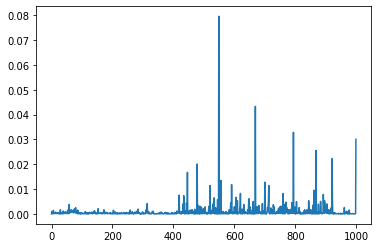

In [ ]:
pred = model.predict(np.array([resized_images[0]]))[0]
import matplotlib.pyplot as plt
plt.plot(pred)
plt.show()

In [ ]:

convoluted_array = np.empty(shape=(0, 224*224*3))
for j in range(0, len(resized_images)):
    # pred = model.predict(np.array([resized_images[j]]))
    pred = resized_images[j].flatten().reshape(1,224*224*3)

    convoluted_array = np.append(convoluted_array, pred, axis=0)
print(convoluted_array.shape)

(29, 150528)


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.99)
pca.fit(convoluted_array)
print(pca.n_components_)

21


In [ ]:
decomposed_array = pca.transform(convoluted_array)
print(decomposed_array.shape)

(29, 21)


In [ ]:
max_length = 29
n_features = pca.n_components_
output = 224*224*3
X = np.empty(shape=(0, max_length, output))
y = np.empty(shape=(0, output))
c = 0
def pad_seq(im_seq, max_len):
    empty = np.zeros(im_seq[0].shape)
    result = []
    ep = [empty] * (max_len - len(im_seq))
    for i in range(0, len(ep)):
        result.append(ep[i])
    for i in range(0, len(im_seq)):
        result.append(im_seq[i])
    return np.array(result, dtype='float64')


for i in range(0, len(decomposed_array) - 1):
    inp = convoluted_array[0:c+1]
    # inp = decomposed_array[0:c + 1]
    inp = pad_seq(inp, max_length)
    target = resized_images[c+1].reshape(1,224*224*3)
    X = np.append(X, [inp], axis=0)
    y = np.append(y, target, axis=0)
    c += 1
print(X.shape)
print(y.shape)

(28, 29, 150528)
(28, 150528)


Epoch 1/300
1/1 [==============================] - 3s 3s/step - loss: 0.2987 - val_loss: 0.2701
Epoch 2/300
1/1 [==============================] - 0s 417ms/step - loss: 0.2690 - val_loss: 0.2198
Epoch 3/300
1/1 [==============================] - 0s 414ms/step - loss: 0.2225 - val_loss: 0.1625
Epoch 4/300
1/1 [==============================] - 0s 406ms/step - loss: 0.1597 - val_loss: 0.1120
Epoch 5/300
1/1 [==============================] - 0s 401ms/step - loss: 0.1151 - val_loss: 0.0744
Epoch 6/300
1/1 [==============================] - 0s 417ms/step - loss: 0.0739 - val_loss: 0.0495
Epoch 7/300
1/1 [==============================] - 0s 430ms/step - loss: 0.0484 - val_loss: 0.0341
Epoch 8/300
1/1 [==============================] - 0s 411ms/step - loss: 0.0310 - val_loss: 0.0247
Epoch 9/300
1/1 [==============================] - 0s 423ms/step - loss: 0.0223 - val_loss: 0.0191
Epoch 10/300
1/1 [==============================] - 0s 409ms/step - loss: 0.0160 - val_loss: 0.0155
Epoch 11/300

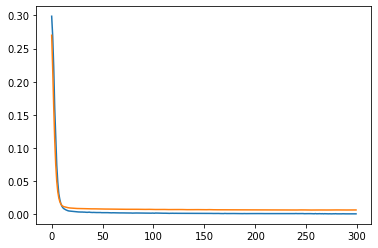

In [ ]:
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import InputLayer


modelLSTM = Sequential()
modelLSTM.add(InputLayer(input_shape=(max_length, output)))
modelLSTM.add(LSTM(units=256, dropout=0.1,))
modelLSTM.add(Dense(256, activation='tanh'))
modelLSTM.add(Dropout(0.5))
modelLSTM.add(Dense(output, activation='tanh'))
modelLSTM.compile(loss='msle', optimizer='adam')
h = modelLSTM.fit(X, y, validation_split=0.7, epochs=300, verbose=1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.show()

(224, 224, 3)


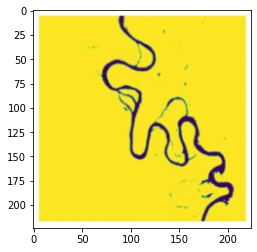

In [ ]:
test_image = resized_images[16]
plt.imshow(test_image)
print(test_image.shape)
plt.show()

In [ ]:
resized_images[-1].shape

(224, 224, 3)

In [ ]:
X[0].shape

(29, 150528)

In [ ]:
decomposed_array[0].shape

(21,)

(1, 29, 150528)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


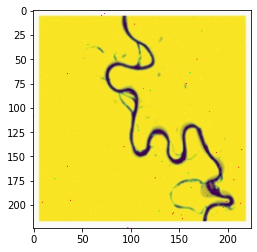

<Figure size 432x288 with 0 Axes>

In [ ]:
from sklearn.metrics import mean_squared_error
%matplotlib inline
results = [resized_images[-1]]
for i in range(1):
  # predn = model.predict(np.array([results[-1]]))
  predn = results[-1].reshape(1,224*224*3)
  # predn = pca.transform(predn)
  # predn = normalize(predn)
  predn = np.array([pad_seq(predn, max_length)])
  print(predn.shape)
  # predn = np.random.rand(1, 29, 17)
  predn = modelLSTM.predict(predn)


  image = predn.reshape(224,224,3)
  # scores = np.empty(0)

  # for i in range(0, len(decomposed_array)):
  #     scores = np.append(scores, mean_squared_error(decomposed_array[i], predn[0]))
  # ims_pics = os.listdir(root)
  # index = np.argmin(scores)
  # image = cv2.imread(root + '/' + ims_pics[index])
  # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # image = cv2.resize(image, (height, width))
  results.append(image)
  # print(ims_pics[index])
  plt.imshow(image)
  plt.savefig('/content/drive/MyDrive/JunctionX/Predictions/{}.png'.format(i))
  plt.show()
  plt.clf()
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 29, 150528)


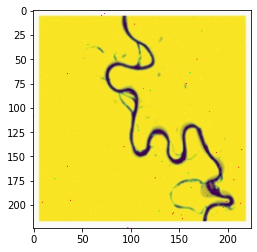

<Figure size 432x288 with 0 Axes>

In [ ]:
from sklearn.metrics import mean_squared_error
%matplotlib inline
results2 = [resized_images[-1]]
for i in range(1):
  predn = results[-1].reshape(1,224*224*3)
  # predn = pca.transform(predn)
  # predn = normalize(predn)
  predn = np.array([pad_seq(predn, max_length)])
  print(predn.shape)
  # predn = np.random.rand(1, 29, 17)
  predn = modelLSTM.predict(predn)


  image = predn.reshape(224,224,3)
  # scores = np.empty(0)

  # for i in range(0, len(decomposed_array)):
  #     scores = np.append(scores, mean_squared_error(decomposed_array[i], predn[0]))
  # ims_pics = os.listdir(root)
  # index = np.argmin(scores)
  # image = cv2.imread(root + '/' + ims_pics[index])
  # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # image = cv2.resize(image, (height, width))
  results.append(image)

  # print(ims_pics[index])
  plt.imshow(image)
  plt.savefig('/content/drive/MyDrive/JunctionX/Predictions/{}_new.png'.format(i))
  plt.show()
  plt.clf()
  plt.show()

In [ ]:
np.sum(results[0] == results2[0])

150528

In [ ]:
np.sum(results[0])

103572.13167892156

In [ ]:
(3731-5160.441828709023)/5160.441828709023

-0.2769998919000747